In [9]:
%reset

In [10]:
import sys
sys.path.append('/home/users/ids29/DGRB')

In [11]:
import aegis
import numpy as np
import healpy as hp
import torch
import pickle as pk
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
rcParams["text.usetex"] = False          # use MathText
rcParams["mathtext.fontset"] = "cm"      # Computer Modern math
rcParams["font.family"] = "serif"
from os import listdir
import os
from sbi.inference import SNPE #, prepare_for_sbi #, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
# from sbi.inference.base import infer
from getdist import plots, MCSamples
import pickle
from scipy.stats import norm, skew, kurtosis, spearmanr
from scipy.integrate import quad, simpson
from joblib import Parallel, delayed
from torch.optim import AdamW
from sbi.neural_nets import posterior_nn
import warnings
from sbi.inference.posteriors import DirectPosterior
from torch.utils.data import DataLoader, TensorDataset, random_split
import copy
from torch.nn.utils import clip_grad_norm_

# torch.set_printoptions(precision=10, sci_mode=True)

%matplotlib inline

In [12]:
warnings.filterwarnings("ignore", category=FutureWarning)

# grains=1000
# num_workers = 11  # or your chosen parallel worker count


# Load training datasets
with open('/home/users/ids29/DGRB Scripts/DM model/Generate Test Data/Emulate ABC paper version 1/combined_test_data.pkl', 'rb') as f:
    data = pickle.load(f) 


use_energy_info = False

print('Completed')

Completed


In [13]:
print(f"Number of photons in test data = {data['energies'].size}")

Number of photons in test data = 502705


In [ ]:
energy_range = [1_000, 100_000] #MeV 
max_radius = 220 #kpc #This is the virial radius of the Milky Way
exposure = 2_000*10*0.2 #cm^2 yr
flux_cut = 1e-9 #photons/cm^2/s
angular_cut_degrees = 180 #degrees # 180 degress is full sky
lat_cut_degrees = 0 #degrees # 0 degrees is full sky
luminosity_range = np.array([1e13, 1e53]) # Minimum value set by considering source at distnace of closest approach by line of sight at 40 degrees and receiving 0.1 photon at detector side. CHANGE THIS FOR FINAL PROBLEM.
                                            # Maximum value set by that value of luminosity that suffieciently suppreses the luminoisity function at the higher end of the luminosity range.


parameter_range_aegis = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*1.5]
angular_cut = angular_cut_degrees*u.deg.to('rad') # radians
angular_cut_gen =  min(angular_cut*1.5, np.pi) # radians
lat_cut = lat_cut_degrees*u.deg.to('rad') # radians
lat_cut_gen = lat_cut*0.5 # radians

In [15]:
my_AEGIS = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range_aegis, energy_range, luminosity_range, max_radius, exposure, angular_cut , lat_cut, flux_cut, energy_range_gen=energy_range_gen, verbose = False)
my_AEGIS.angular_cut_gen, my_AEGIS.lat_cut_gen = angular_cut_gen, lat_cut_gen

In [16]:
def compute_moments(values):
    """Compute the mean and variance of the energies."""
    mean = np.mean(values)
    var = np.var(values)
    skewness = skew(values)
    kurt = kurtosis(values)
    return mean, var, skewness, kurt

def compute_quantiles(values, quantiles=[10, 25, 50, 75, 90]):
    """
    Compute the specified quantiles (in percent).
    For example, the 25th quantile is the energy such that 25% of the data lies below it.
    Returns a dictionary mapping percentiles to values.
    """
    q_values = np.percentile(values, quantiles)
    return dict(zip(quantiles, q_values))

def normalize_quantiles(q_dict, val_min, val_max):
    """
    Normalize quantile values from a dictionary using min-max normalization.
    """
    norm_q = {perc: (val - val_min) / (val_max - val_min) for perc, val in q_dict.items()}
    return norm_q




def effective_spectral_index(energies, E_lower):
    """
    Compute effective spectral index via MLE.
    Returns np.nan if there are no photons.
    """
    energies = np.array(energies)
    n = len(energies)
    if n == 0:
        return np.nan
    sum_logs = np.sum(np.log(energies / E_lower))
    return 1 + n / sum_logs

def smooth_binned_gamma(binned_gamma, counts, global_gamma, min_count=6):
    """
    Smooth binned effective spectral indices if the count in a bin is low.
    
    Parameters:
      binned_gamma : array-like
          Array of spectral indices per energy bin (may contain np.nan for empty bins).
      counts : array-like
          Array of photon counts per bin.
      global_gamma : float
          Global effective spectral index, used as fallback.
      min_count : int
          Minimum photon count required to trust a bin.
    
    Returns:
      smoothed_gamma : numpy array with smoothed spectral index values.
    """
    binned_gamma = np.array(binned_gamma)
    counts = np.array(counts)
    num_bins = len(binned_gamma)
    smoothed_gamma = binned_gamma.copy()

    # Loop over each bin.
    for i in range(num_bins):
        if counts[i] < min_count or np.isnan(binned_gamma[i]):
            indices = [i]
            if i > 0:
                indices.append(i-1)
            if i < num_bins - 1:
                indices.append(i+1)
            indices = list(set(indices))  # ensure uniqueness
            
            # Only include indices with non-NaN values
            valid_indices = [j for j in indices if not np.isnan(binned_gamma[j])]
            if valid_indices:
                # Use the counts as weights. If any count is zero, it's fine; it will reduce the weight.
                weights = np.array([counts[j] for j in valid_indices], dtype=np.float32)
                # If all weights sum to 0, default to global_gamma.
                if np.sum(weights) > 0:
                    smoothed_gamma[i] = np.average(binned_gamma[valid_indices], weights=weights)
                else:
                    smoothed_gamma[i] = global_gamma
            else:
                # If none of the neighboring bins have a valid estimate, fallback to global_gamma.
                smoothed_gamma[i] = global_gamma
    return smoothed_gamma

def compute_binned_effective_spectral_indices(energies, num_bins, energy_range):
    """
    Divide the energy range into logarithmic bins and compute the effective spectral index in each bin.
    For bins with few photons (count < min_count) or empty bins, apply smoothing by averaging with neighboring bins.
    
    Returns:
      smoothed_gamma : 1D array containing the (possibly smoothed) spectral index for each bin.
      global_gamma  : Effective spectral index computed using all energies (with the lowest bin edge as E_lower).
      counts        : Raw photon counts per bin.
    """
    bins = np.geomspace(energy_range[0], energy_range[1], num_bins + 1)
    binned_gamma = []
    counts = []  # photon counts per bin

    # Loop over bins
    for i in range(len(bins) - 1):
        mask = (energies >= bins[i]) & (energies < bins[i+1])
        energies_bin = energies[mask]
        counts.append(len(energies_bin))
        # Compute gamma for the bin; if the bin is empty, effective_spectral_index returns np.nan.
        gamma = effective_spectral_index(energies_bin, E_lower=bins[i])
        binned_gamma.append(gamma)
    
    binned_gamma = np.array(binned_gamma)
    counts = np.array(counts)
    
    # Compute the global effective spectral index over all energies using the first bin's lower edge.
    global_gamma = effective_spectral_index(energies, E_lower=bins[0])
    
    # Smooth the binned_gamma using neighboring bins if counts in a bin are low.
    smoothed_gamma = smooth_binned_gamma(binned_gamma, counts, global_gamma, min_count=6)
    
    return smoothed_gamma, global_gamma, counts




def normalize_binned_gamma(binned_gamma, global_gamma, mode='ratio'):
    """
    Normalize the binned effective spectral indices relative to the global effective spectral index.
    
    Parameters:
      binned_gamma : np.array
          Array of effective spectral indices for each energy bin.
      global_gamma : float
          The global effective spectral index computed over the entire energy range.
      mode : str, optional
          'ratio' for normalized_binned_gamma = binned_gamma / global_gamma,
          'difference' for normalized_binned_gamma = (binned_gamma - global_gamma)/global_gamma.
          Default is 'ratio'.
    
    Returns:
      normalized_binned_gamma : np.array
    """
    if mode == 'ratio':
        # Return ratio relative to global spectral index
        normalized_binned_gamma = binned_gamma / global_gamma
    elif mode == 'difference':
        # Return relative differences with baseline 0
        normalized_binned_gamma = (binned_gamma - global_gamma) / global_gamma
    else:
        raise ValueError("Unknown mode for normalization. Choose 'ratio' or 'difference'.")
    return normalized_binned_gamma


# --- concise, log-binned 1-D energy histogram ---------------------------
def compute_energy_only_histogram(energies, num_bins, energy_range=(1000, 100_000)):
    """
    Log-bin photon energies (MeV) into `num_bins` and return raw counts.

    Parameters
    ----------
    energies      : 1-D iterable (list / np.ndarray / torch.Tensor)
    num_bins      : int, number of logarithmic bins
    energy_range  : (low, high) edges in MeV  (default 1–100 GeV)

    Returns
    -------
    hist : 1-D np.ndarray length `num_bins`  (integer counts)
    """
    edges = np.geomspace(energy_range[0], energy_range[1], num_bins + 1, dtype=np.float32)
    hist, _ = np.histogram(np.asarray(energies, dtype=np.float32), bins=edges)
    return hist.astype(np.float32)


def normalize_energy_only_hist(energy_only_hist):
    """
    Normalize a 1D histogram so it sums to 1.
    """
    total = np.sum(energy_only_hist) # this is the total number of photons in the energy-only histogram
    if total == 0:
        return energy_only_hist  # or handle the zero-case as needed
    return energy_only_hist / total

# def compute_sub_statistics(energies, counts, N_Ebins):
#     """
#     Given an array of photon energies (all between 1 and 100 GeV), compute a set of summary statistics:
#       1. Mean energy.
#       2. Variance of energy.
#       3. Quantiles: 10%, 25%, 50%, 75%, and 90%.
#       4. Effective spectral index estimated from the data.
      
#     Returns the statistics in a dictionary and also a flattened torch tensor.
#     """
#     # 1. Mean and variance
#     mean_E, var_E, skewness_E, kurt_E  = compute_moments(energies)
#     mean_counts, var_counts, skewness_counts, kurt_counts  = compute_moments(counts)
    
#     # 2. Quantiles
#     quant_dict_E = compute_quantiles(energies)  # This returns a dict like {10: val, 25: val, ...}
#     norm_quant_dict_E = normalize_quantiles(quant_dict_E, val_min=energy_range[0], val_max=energy_range[1])

#     quant_dict_counts = compute_quantiles(counts)  # This returns a dict like {10: val, 25: val, ...}
#     norm_quant_dict_counts = normalize_quantiles(quant_dict_counts, val_min=0, val_max=np.max(counts))

#     energy_only_hist = compute_energy_only_histogram(energies, num_bins=N_Ebins, energy_range=energy_range)

#     binned_gamma, global_gamma, energy_only_hist = compute_binned_effective_spectral_indices(energies, num_bins=N_Ebins, energy_range=energy_range)
#     norm_binned_gamma = normalize_binned_gamma(binned_gamma, global_gamma, mode='ratio')
#     norm_energy_only_hist = normalize_energy_only_hist(energy_only_hist)
    
#     # If you want to pass the summary statistic to sbi, it is best to use a fixed-size vector (e.g., a torch tensor).
#     # For example, arrange the stats in a consistent order:
#     scalars  = np.array([
#         energies.size, # total number of photons
#         mean_E, var_E , skewness_E, kurt_E,
#         mean_counts, var_counts, skewness_counts, kurt_counts,
#         global_gamma
#     ], dtype=np.float32)

    
#     return scalars , norm_quant_dict_E, norm_quant_dict_counts, norm_binned_gamma, norm_energy_only_hist

def compute_sub_statistics(energies, counts, N_Ebins):
    """
    Given an array of photon energies (all between 1 and 100 GeV), compute a set of summary statistics:
      1. Mean energy.
      2. Variance of energy.
      3. Quantiles: 10%, 25%, 50%, 75%, and 90%.
      4. Effective spectral index estimated from the data.
      
    Returns the statistics in a dictionary and also a flattened torch tensor.
    """
    # 1. Mean and variance
    mean_E, var_E, skewness_E, kurt_E  = compute_moments(energies)
    mean_counts, var_counts, skewness_counts, kurt_counts  = compute_moments(counts)
    
    # 2. Quantiles
    quant_dict_E = compute_quantiles(energies)  # This returns a dict like {10: val, 25: val, ...}
    norm_quant_dict_E = normalize_quantiles(quant_dict_E, val_min=energy_range[0], val_max=energy_range[1])

    quant_dict_counts = compute_quantiles(counts)  # This returns a dict like {10: val, 25: val, ...}
    norm_quant_dict_counts = normalize_quantiles(quant_dict_counts, val_min=0, val_max=np.max(counts))

    energy_only_hist = compute_energy_only_histogram(energies, num_bins=N_Ebins, energy_range=energy_range)

    binned_gamma, global_gamma, energy_only_hist = compute_binned_effective_spectral_indices(energies, num_bins=N_Ebins, energy_range=energy_range)
    norm_binned_gamma = normalize_binned_gamma(binned_gamma, global_gamma, mode='ratio')
    norm_energy_only_hist = normalize_energy_only_hist(energy_only_hist)
    
    # If you want to pass the summary statistic to sbi, it is best to use a fixed-size vector (e.g., a torch tensor).
    # For example, arrange the stats in a consistent order:
    energy_only_scalars  = np.array([
        mean_E, var_E , skewness_E, kurt_E,
        global_gamma
    ], dtype=np.float32)

    other_scalars  = np.array([
        np.log10(energies.size), #total number of photons
        mean_counts, var_counts, skewness_counts, kurt_counts,
    ], dtype=np.float32)

    
    # USES NORMALIZED SUMMARIES
    # return energy_only_scalars, other_scalars, norm_quant_dict_E, norm_quant_dict_counts, norm_binned_gamma, norm_energy_only_hist

    # USES UN-NORMALIZED SUMMARIES
    return energy_only_scalars, other_scalars, quant_dict_E, quant_dict_counts, binned_gamma, energy_only_hist

def normalize_energy_dependent_hist(energy_dependent_hist, total_pixels):
    """
    Normalize a 2D histogram so that each column sums to 1.
    total_pixels: the fixed number of pixels (for example, len(roi_pix_i))
    """
    # If the histogram is of shape (N_countbins, N_Ebins),
    # each column should ideally sum to total_pixels.
    normalized_hist = energy_dependent_hist / total_pixels
    return normalized_hist

def fano_from_photons(photon_info, nsides=(32, 64, 128), center_mask_deg=10, lat_mask_deg=5): #Outputs an array of Fano factors for each NSIDE (currently three in number).
    """
    photon_info must expose `theta` (co-latitude, rad) and `phi` (longitude, rad).
    Returns ΔF for each NSIDE in `nsides`.
    """
    # theta_p = photon_info['theta']   # or however your struct stores it
    # phi_p   = photon_info['phi']

    if photon_info['energies'].size == 0: # handles the case where there are no photons in the skymap
        fanos_excess = [-1, -1, -1]
        dont_trust_fano = 1

        return np.asarray(fanos_excess, dtype=np.float32), dont_trust_fano

    # There are at least 1 photons
    fanos_excess = []
    dont_trust_fano = 0
    for N_side in nsides:

        N_pix = 12*N_side**2
        pix_i = np.linspace(0, N_pix-1, N_pix, dtype = 'int')
        roi_pix_i = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask_deg*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask_deg*u.deg.to('rad')))[0]

        N_Ebins = 1 # This value doesn't matter because in 'get_roi_map_summary' fucntion, when you use 'Ebinspace = single', it will only consider one energy bin, and not use the N_Ebins value.
        roi_map_1D = my_AEGIS.get_roi_map_summary(photon_info = photon_info, N_side = N_side, N_Ebins = N_Ebins, Ebinspace = 'single', roi_pix_i = roi_pix_i) # 'single' means only one energy bin.
        counts = roi_map_1D.ravel()

        #Fano excess
        mu  = counts.mean()
        var = counts.var()

        if mu == 0: # No photons in ROI skymap, but photons in overall skymap
            fanos_excess = [-1, -1, -1]
            dont_trust_fano = 1
            return np.asarray(fanos_excess, dtype=np.float32), dont_trust_fano
            #print(f"maximum counts in any ROI pixel = {counts.max()}; mean_counts = {mu}; variance_counts = {var}; fano factor = {var/mu - 1}; Number of photons  = {photon_info['energies'].shape}")
        else: # mu>0 case
            fano = var/mu - 1
            fanos_excess.append(fano)
        
        

    return np.asarray(fanos_excess, dtype=np.float32), dont_trust_fano

def fano_from_photons_energy_dependent(photon_info, center_mask_deg, lat_mask_deg, N_Ebins, nsides=(32, 64, 128, 256)): #Outputs an array of Fano factors for each NSIDE (currently three in number).

    if photon_info['energies'].size == 0: # handles the case where there are no photons in the skymap
        fano_excess = np.full((len(nsides), N_Ebins), -1) # Initialize a 2D array to store Fano factors for each NSIDE and energy bin. '-1' is a sentinnel value indicating no valid Fano factor computed.
        dont_trust_fano = np.ones((len(nsides), N_Ebins)) # Initialize a 2D array to store trust status for each NSIDE and energy bin. 0 means trust, 1 means don't trust.

        return np.asarray(fano_excess, dtype=np.float32), dont_trust_fano

    # There are at least 1 photons
    fano_excess = np.full((len(nsides), N_Ebins), -1.0) # Initialize a 2D array to store Fano factors for each NSIDE and energy bin. '-1' is a sentinnel value indicating no valid Fano factor computed.
    dont_trust_fano = np.ones((len(nsides), N_Ebins)) # Initialize a 2D array to store trust status for each NSIDE and energy bin. 0 means trust, 1 means don't trust.

    for i, N_side in enumerate(nsides):

        N_pix = 12*N_side**2
        pix_i = np.linspace(0, N_pix-1, N_pix, dtype = 'int')
        roi_pix_i = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask_deg*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask_deg*u.deg.to('rad')))[0]

        roi_map_2D = my_AEGIS.get_roi_map_summary(photon_info = photon_info, N_side = N_side, N_Ebins = N_Ebins, Ebinspace = 'log', roi_pix_i = roi_pix_i)
        print()

        #Fano excess for each energy bin
        mu  = np.mean(roi_map_2D, axis=0)
        var = np.var(roi_map_2D, axis=0)
        # print(f"mu = {mu}; var = {var}")

        # 1) build a mask of “valid” bins (where mu>0) and compute fano_excess
        # UPDATE THE NEXT LINE OF CODE
        # mask = (mu > 0)  & # make sure there are more than 6 photons in each energy bin to compute the fano excess      # shape (N_Ebins,)

        fano_excess[i, mask] = var[mask] / mu[mask] - 1
        # print(f"fano_excess[i, mask] = {fano_excess[i, mask]}; var[mask] / mu[mask] - 1 = {var[mask] / mu[mask] - 1}")
        dont_trust_fano[i, mask] = 0


        # for j in range(N_Ebins):
        #     # if mu[j] == 0: # For this energy bin, no photons in ROI skymap, but photons in overall skymap
        #         # fano_excess[i,j] = -1 # already initialized to -1
        #         # dont_trust_fano[i,j] = 1 # already initialized to -1
        #     if mu[j] > 0: 
        #         fano_excess[i,j] = var[j]/mu[j] - 1
        #         dont_trust_fano[i,j] = 0
        #         print(f"var[j]/mu[j] - 1 = {var[j]/mu[j] - 1}; fano_excess[i,j] = {fano_excess[i,j]}")

    return fano_excess, dont_trust_fano




print('Completed')

Completed


Generate maximum counts-in-a-pixel for each energy bin

In [17]:
# # a simple simulator with the total number of photons as the summary statistic
# def compute_summary_statistics(photon_info):
    
#     center_mask = 60 #deg
#     lat_mask = 30 #deg 
#     N_Ebins = 10
#     # Ebinspace = 'log'#'linear'
#     N_countbins = 10
#     countbinspace = 'custom'#'linear'
#     mincount_2D_hist, maxcount_2D_hist = np.zeros(10), np.array([25, 17,  11,  8,   8,   8,   5,  5,  5,  4]) # For 10 energy bins.  # For energy-dependent 2D histogram # CHANGE FOR DIFFERENT DATASETS. Consider the data set with the maximum number of photons to decide the value of 'maxcount'.
#     mincount_1D_counts_hist, maxcount_1D_counts_hist = 0, 55 # For counts only 1D histogram # CHANGE FOR DIFFERENT DATASETS. Consider the data set with the maximum number of photons to decide the value of 'maxcount'.
    
#     N_side = 64
#     N_pix = 12*N_side**2
#     pix_i = np.linspace(0, N_pix-1, N_pix, dtype = 'int')
#     roi_pix_i = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')))[0]

#     # Get energy dependent 2D histogram
    
#     roi_map_2D = my_AEGIS.get_roi_map_summary(photon_info = photon_info, N_side = N_side, N_Ebins = N_Ebins, Ebinspace = 'log', roi_pix_i = roi_pix_i)
#     # print(f"roi_map_2D.shape = {roi_map_2D.shape}, N_Ebins = {N_Ebins}; roi_pix_i.size = {roi_pix_i.size}")
    
    
#     max_counts = np.max(roi_map_2D, axis=0)

#     return max_counts
    

# print('Completed')

In [18]:
# summaries = Parallel(
#     n_jobs=num_workers,           # number of worker processes
#     backend="loky",      # default multiprocess backend
#     #verbose=10           # progress output
# )(
#     delayed(compute_summary_statistics)(raw) 
#     for raw in raw_train
# )
# # print(summaries)

# summaries_stacked = np.vstack(summaries)
# print(f"summaries_stacked.shape = {summaries_stacked.shape}; Expected shape = (11, 10)")

# max_counts_in_pixel = np.max(summaries_stacked, axis=0)
# print(f"max_counts_in_pixel.shape = {max_counts_in_pixel.shape}; Expected shape = (10,)")
# print(f"max_counts_in_pixel = {max_counts_in_pixel}")
# # np.save('max_counts_in_pixel.npy', max_counts_in_pixel)

Generate 2D counts-energy histogram - use maximum counts-in-a-pixel = 35 for every energy bin

In [ ]:
# a simple simulator with the total number of photons as the summary statistic
def compute_summary_statistics(photon_info):
    
    center_mask = 0 #deg
    lat_mask = 0 #deg 
    N_Ebins = 10
    # Ebinspace = 'log'#'linear'
    N_countbins = 20
    countbinspace = 'linear' #'arange' #'custom' #'linear' #using 'arange' countbinspace; if mincount=0 and maxcount=8, then counts_bin_array=[0,1,2,4,6,8] #
    mincount_2D_hist, maxcount_2D_hist = 0, 70 # CHANGE FOR DIFFERENT DATASETS. # For 10 energy bins.  # For energy-dependent 2D histogram . Consider the data set with the maximum number of photons to decide the value of 'maxcount'.
    # mincount_1D_counts_hist, maxcount_1D_counts_hist = 0, 55 # CHANGE FOR DIFFERENT DATASETS. # For counts only 1D histogram . Consider the data set with the maximum number of photons to decide the value of 'maxcount'.
    
    N_side = 64
    N_pix = 12*N_side**2
    pix_i = np.linspace(0, N_pix-1, N_pix, dtype = 'int')
    roi_pix_i = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')))[0]

    # Get energy dependent 2D histogram - regular
    
    roi_map_2D_unclipped, E_bin_edges = my_AEGIS.get_roi_map_summary(photon_info = photon_info, N_side = N_side, N_Ebins = N_Ebins, Ebinspace = 'log', roi_pix_i = roi_pix_i)
    roi_map_2D = np.minimum(roi_map_2D_unclipped, maxcount_2D_hist) # For each energy bin, we clip the values of counts-in-a-pixel stored in
                                                            # 'roi_map_2D_unclipped' on higher end, to the value stored in 'maxcount_2D_hist'
                                                            # NOte that 'maxcount_2D_hist' is broadcasted to 2 dimensions by the np.minimum() function

   
    hist_2d, counts_bin_edges = my_AEGIS.get_counts_histogram_from_roi_map(roi_map_2D, mincount = mincount_2D_hist, maxcount = maxcount_2D_hist, N_countbins = N_countbins, countbinspace = countbinspace)
    


    assert hist_2d.shape == (len(counts_bin_edges)-1, len(E_bin_edges)-1)
    
    E_edges_GeV = E_bin_edges / 1e3
    Z = hist_2d.T  # shape becomes (n_energy_bins, n_counts_bins)


    # compute log10 only where Z>0 (no warnings)
    Z_log = np.full(Z.shape, np.nan, dtype=float)
    pos = Z > 0
    Z_log[pos] = np.log10(Z[pos])
    
    cmap = mpl.colormaps['viridis'].copy()
    cmap.set_bad('0.5')

    fig, ax = plt.subplots(figsize=(6.5, 4.8))
    mesh = ax.pcolormesh(counts_bin_edges, E_edges_GeV, Z_log, shading='auto', cmap=cmap)

    ax.set_yscale('log')
    ax.set_xlabel(r'$C$', fontsize=18)
    ax.set_ylabel(r'$\mathrm{Energy [GeV]}$', fontsize=18)

    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label(r'$\log_{10}\ \mathrm{Pixels}$', fontsize=18)

    ax.set_xlim(counts_bin_edges[0], counts_bin_edges[-1])
    ax.set_ylim(E_edges_GeV[0], E_edges_GeV[-1])
    plt.tight_layout()
    plt.show()
    


    

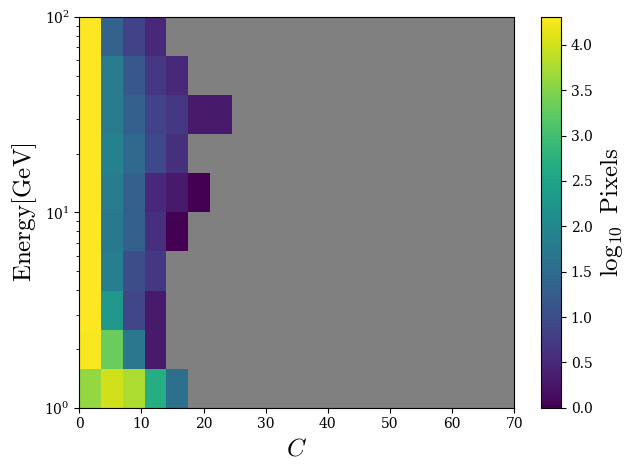

In [20]:
compute_summary_statistics(data)